# Tutorial 4: Choosing the Right Model and Estimator

So far, we've learned how to prepare our data and optimize processing parameters like `window_size`. Now, we need to look inside the 'black box' and understand the two most important choices that determine the success of our MI estimate:

1.  **The Critic Architecture**: The neural network that *compares* the data from X and Y.
2.  **The MI Estimator**: The loss function that *trains* the critic.

Getting these right is key to capturing the true nature of the relationship in your data. This tutorial will provide the intuition and practical examples to guide your choices.

In [1]:
import torch
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import Sequential, Linear, Softplus

sns.set_context("talk")

## Part 1: Choosing the Critic Architecture

Think of the critic's job as being a sophisticated comparison function, `f(x, y)`. The complexity of this function determines the kinds of relationships the model can find. `NeuralMI` provides three main critic types, each with a different balance of computational cost and expressive power.

| Critic Type | How it Works | Power | Cost | Use Case |
| :--- | :--- | :--- | :--- | :--- |
| **`SeparableCritic`** | Compares embeddings with a simple dot product: `g(x) • h(y)`. | Low | Low | **Default choice.** Fast and effective for most relationships. |
| **`BilinearCritic`** | Uses a learnable matrix to compare embeddings: `g(x)ᵀ W h(y)`. | Medium | Medium | Good for more complex relationships, like rotations, without a huge speed penalty. |
| **`ConcatCritic`** | Concatenates inputs `[x, y]` into a single powerful network `f(x, y)`. | High | High | The most powerful, but can be very slow. Use when other critics fail. |

### The Test: The Rotated Manifold Problem

To see the difference, we'll create a special dataset. We'll generate a high-dimensional `X` from a latent variable `Z`, and a high-dimensional `Y` from a **rotated** version of `Z`. A simple `SeparableCritic` (dot product) will struggle to see that these are related, but the more powerful critics should succeed. Also note that MI here is bounded by the entropy of `Z` (`I(X;Y)~I(Z;Z)~H(Z)`) which can be infinte. Thus, we are not interested in the exact value of MI, but rather the trends. 

In [2]:
# 1. Create the shared latent variable Z
n_samples = 5000
z = torch.randn(n_samples, 2)

# 2. Create a 45-degree rotation matrix for Y's latent variable
angle = np.pi / 4
rotation_matrix = torch.tensor([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]], dtype=torch.float32)
z_rotated = z @ rotation_matrix

# 3. Create nonlinear mappings from latent to a high-dimensional observed space
mlp = Sequential(Linear(2, 64), Softplus(), Linear(64, 50))
x_raw = mlp(z).T.detach()
y_raw = mlp(z_rotated).T.detach()

In [3]:
# Now we sweep over the critic types to see which one can solve the task
sweep_grid = {
    'critic_type': ['separable', 'bilinear', 'concat'],
    'run_id': range(5) # Average over 5 runs for stability
}

base_params = {
    'n_epochs': 100, 'learning_rate': 5e-4, 'batch_size': 64,
    'patience': 20, 'embedding_dim': 8, 'hidden_dim': 64, 'n_layers': 3
}

critic_results = nmi.run(
    x_data=x_raw, y_data=y_raw,
    mode='sweep',
    processor_type_x='continuous',
    processor_params_x={'window_size': 1},
    base_params=base_params,
    sweep_grid=sweep_grid,
    n_workers=1, # Because concat is very costly, running multiple instances of it together will likely crash the device
    random_seed=42
)

2025-10-08 02:15:25 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c0:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c1:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c2:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c3:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c4:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c5:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c6:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c7:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c8:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c9:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c10:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c11:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c12:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c13:   0%|          | 0/100 [00:00<?, ?it/s]

Run 575a2d20-7306-44e2-b38a-fdef5cfa9c67_c14:   0%|          | 0/100 [00:00<?, ?it/s]

2025-10-08 02:24:47 - neural_mi - INFO - Parameter sweep finished.


### The Result: Sort of a Hierarchy

The results might show a hierarchy in power. The `SeparableCritic` finds the lowest MI. The `BilinearCritic` does better, as its learnable matrix `W` can effectively undo the rotation. The `ConcatCritic`, being the most powerful, also succeeds, achieving a slightly higher MI at the cost of being slower.

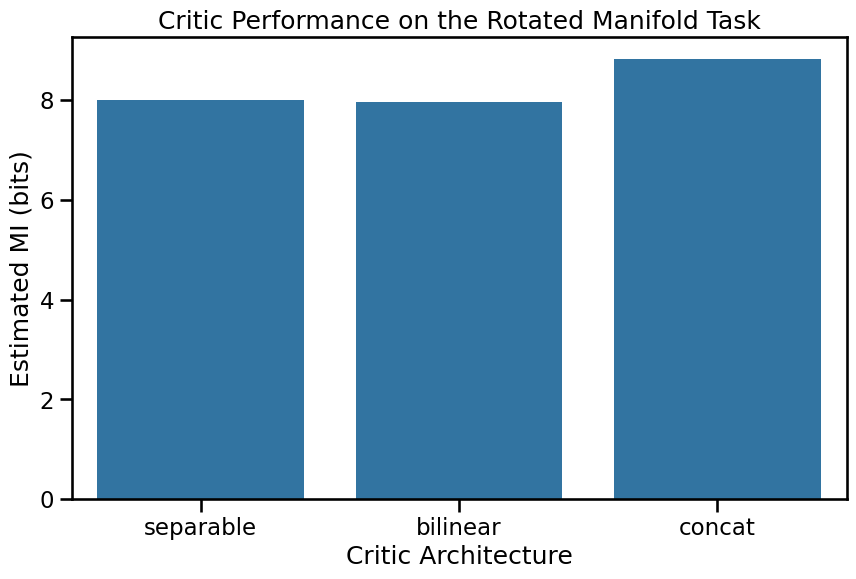

In [4]:
plt.figure(figsize=(10, 6))
sns.barplot(data=critic_results.dataframe, x='critic_type', y='mi_mean', capsize=0.1, order=['separable', 'bilinear', 'concat'])
plt.title('Critic Performance on the Rotated Manifold Task')
plt.ylabel('Estimated MI (bits)')
plt.xlabel('Critic Architecture')
plt.ylim(bottom=0)
plt.show()

## Part 2: Choosing the MI Estimator

The estimator is the loss function used to train the critic. The choice of estimator involves a crucial trade-off between **bias** and **variance**.

| Estimator | Bias | Variance | Use Case |
| :--- | :--- | :--- | :--- |
| **`InfoNCE`** | High (Biased Low) | Low | **Default choice.** Very stable. Excellent for most tasks where the true MI isn't extremely high. |
| **`SMILE`** | Low | Medium | Less biased. Use when you suspect the true MI is very high, as it can avoid the artificial ceiling that affects `InfoNCE`. |

### The Problem: The `InfoNCE` Upper Bound

The `InfoNCE` estimator is mathematically bounded by `log(batch_size)`. This means it can never report an MI value higher than this limit. For a batch size of 128, the limit is `log(128) ≈ 4.85` nats or `6.99` bits. If the true MI is higher than this, `InfoNCE` will underestimate it.

Let's create a dataset with a known **ground truth MI of 8.0 bits** and see how the two estimators perform.

In [5]:
ground_truth_mi = 8.0
batch_size = 128
infonce_limit_bits = np.log(batch_size) / np.log(2)

x_high_mi, y_high_mi = nmi.datasets.generate_correlated_gaussians(
    n_samples=10000, dim=20, mi=ground_truth_mi
)

# Use a powerful model to ensure the estimator is the limiting factor
high_mi_params = {
    'n_epochs': 100, 'learning_rate': 5e-4, 'batch_size': batch_size,
    'patience': 20, 'embedding_dim': 32, 'hidden_dim': 128, 'n_layers': 3
}

print("--- Running with InfoNCE (default) ---")
infonce_results = nmi.run(
    x_data=x_high_mi.T, y_data=y_high_mi.T, mode='estimate',
    processor_type_x='continuous', processor_params_x={'window_size': 1},
    base_params=high_mi_params, estimator='infonce', random_seed=42
)

print("\n--- Running with SMILE ---")
smile_results = nmi.run(
    x_data=x_high_mi.T, y_data=y_high_mi.T, mode='estimate',
    processor_type_x='continuous', processor_params_x={'window_size': 1},
    base_params=high_mi_params, estimator='smile', estimator_params={'clip': 5}, random_seed=42
)

print("\n--- Comparison ---")
print(f"Ground Truth MI:      {ground_truth_mi:.3f} bits")
print(f"InfoNCE Limit:          {infonce_limit_bits:.3f} bits")
print(f"InfoNCE Estimate:       {infonce_results.mi_estimate:.3f} bits")
print(f"SMILE Estimate:         {smile_results.mi_estimate:.3f} bits")

--- Running with InfoNCE (default) ---
2025-10-08 02:29:00 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Run 45ae83b3-50d4-41e1-a4d6-55441f58de84_c0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-10-08 02:29:13 - neural_mi - INFO - Parameter sweep finished.

--- Running with SMILE ---
2025-10-08 02:29:13 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Run f36d2339-85dc-4d46-8fac-dc8cc83b71e3_c0:   0%|          | 0/100 [00:00<?, ?it/s]

2025-10-08 02:29:39 - neural_mi - INFO - Parameter sweep finished.

--- Comparison ---
Ground Truth MI:      8.000 bits
InfoNCE Limit:          7.000 bits
InfoNCE Estimate:       5.795 bits
SMILE Estimate:         8.868 bits


The results are interesting: `InfoNCE` approaches its artificial ceiling and underestimates the true MI. `SMILE`, being less biased, provides a higher -and noiser- estimate. This is why `SMILE` is the recommended choice for `mode='dimensionality'`, where we don't care that much about the exact value of MI, rather its trend, and the internal information can be very high.

This result then should invite us to rethink the difference between the critics we noticed earlier, is it a *true* saturation, or an artifact of `InfoNCE`?

### Critic Architecture, Revisited:

In [7]:
critic_results_smile = nmi.run(
    x_data=x_raw, y_data=y_raw,
    mode='sweep',
    processor_type_x='continuous',
    processor_params_x={'window_size': 1},
    estimator='smile', estimator_params={'clip': 5},
    base_params=base_params,
    sweep_grid=sweep_grid,
    n_workers=1, # Because concat is very costly, running multiple instances of it together will likely crash the device
    random_seed=42
)

2025-10-08 03:08:04 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c0:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c1:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c2:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c3:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c4:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c5:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c6:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c7:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c8:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c9:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c10:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c11:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c12:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c13:   0%|          | 0/100 [00:00<?, ?it/s]

Run 435322e3-f56e-4977-b640-96d62dfc6493_c14:   0%|          | 0/100 [00:00<?, ?it/s]

2025-10-08 03:15:22 - neural_mi - INFO - Parameter sweep finished.


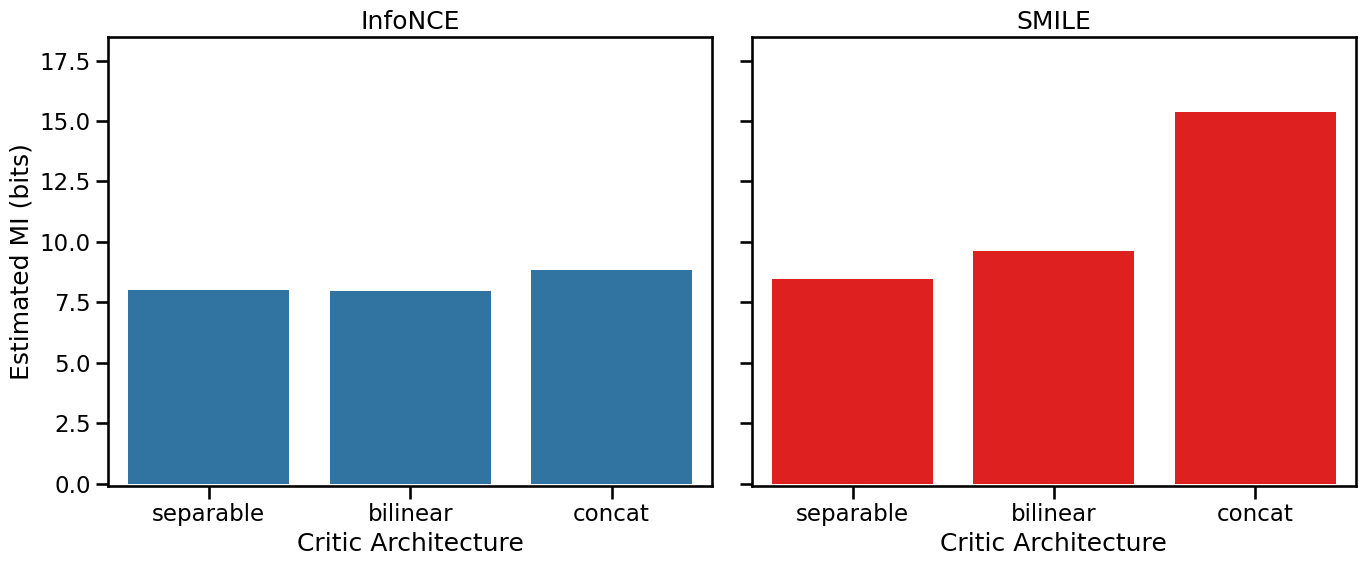

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.barplot(
    data=critic_results.dataframe,
    x='critic_type',
    y='mi_mean',
    capsize=0.1,
    order=['separable', 'bilinear', 'concat'],
    ax=axes[0]
)
axes[0].set_title('InfoNCE')
axes[0].set_ylabel('Estimated MI (bits)')
axes[0].set_xlabel('Critic Architecture')
axes[0].set_ylim(bottom=0)

sns.barplot(
    data=critic_results_smile.dataframe,
    x='critic_type',
    y='mi_mean',
    capsize=0.1,
    order=['separable', 'bilinear', 'concat'],
    ax=axes[1],
    color='red'
)
axes[1].set_title('SMILE')
axes[1].set_xlabel('Critic Architecture')
axes[1].set_ylim(-0.1, 1.2*critic_results_smile.dataframe.mi_mean.max())

plt.tight_layout()
plt.show()

### The New Result: A Clear Hierarchy

The new results show a clear hierarchy in power. The `SeparableCritic` finds the lowest MI. The `BilinearCritic` does better, as its learnable matrix `W` can effectively undo the rotation. The `ConcatCritic`, being the most powerful, also succeeds, achieving a significantly higher MI at the cost of being slower.

## Conclusion and Recommendations

Choosing the right architecture and estimator is a trade-off. Here's a simple guide to get started:

> **Recommendation:** Always start with the default: a **`SeparableCritic`** and the **`InfoNCE`** estimator. This combination is fast, stable, and works for a wide variety of problems.

- If you have reason to suspect a complex, non-linear relationship (like a rotation or other geometric transformation), try the **`BilinearCritic`**. It offers a significant power boost without the high cost of the `ConcatCritic`.

- If you are estimating the internal dimensionality of a system (`mode='dimensionality'`) or have other reasons to believe the true MI is very high, switch to the **`SMILE`** estimator to get a less biased result.

With these guidelines, you are now equipped to make informed decisions about the core components of your MI analysis. In the next tutorial, we will tackle the final and most important step for scientific rigor: correcting for finite-sampling bias to get a statstically sound result.

*A note*: While the theoretical bound of `InfoNCE` is `log(batch_size)`, this is the case during the *training*. i.e., we should never see an MI value when we're training the estimator that exceeds this bound. However, when evaluating on the whole dataset, the MI value can be bigger, as now the batch size is bigger.